# Data Wrangling

- 1. [Introduction](#1.-Introduction)
- 2. [Imports](#2.-Imports)
- 3. [Loading the Data](#3.-Loading-the-Data)
- 4. [Enforcing Statistical Independence](#4.-Enforcing-Statistical-Independence)
- 5. [Handling Missing Values](#5.-Handling-Missing-Values)
    - 4.1 Which features have a high proportion of missing/not available values?
    - 4.2 Race
    - 4.3 Medical Specialty
    - 4.4 Diagnoses
    - 4.5 Hemoglobin A1C result
    - 4.6 Glucose Serum test result
    - 4.7 Payer code
    - 4.8 Weight
- 6. [Handling Nominal Features](#6.-Handling-Nominal-Features)
    - 6.1 Medication-related Features
    - 6.2 Admission type
    - 6.3 Discharges
    - 6.4 Admission source
    - 6.5 Early Readmission
- 7. [Handling Outliers for Numerical Features](#7.-Handling-Outliers-for-Numerical-Features)
- 8. [Exporting Preprocessed Data](#8.-Exporting-Preprocessed-Data)

# 1. Introduction

For this project, we're interested in predicting early readmission of diabetic patients; that is, hospital re-admission occurring within 30 days of an initial encounter. The data of interest is downloaded from [the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). It captures demographic, diagnosis, and medication-related features for diabetic in-patient encounters at US hospitals during 1999 to 2008.

This notebook will perform basic data wrangling operations: data cleaning, imputation, and outlier handling. 

# 2. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from data import load_dataset as ld
from features.icd9 import icd9_to_classification

pd.options.display.max_columns = 100
sns.set()

# 3. Loading the Data

In [3]:
df = ld.load_raw_data()
original_shape = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


# 4. Enforcing Statistical Independence

We will find that some of these observations are dependent on each other because there can exist more than one patient encounter per patient:

In [4]:
df.patient_nbr.value_counts()

88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64

This violates statistical assumptions made by learners like logistic regression, where we assume that each observation is independent from one another. Having more weight on a subset of patient encounters will bias the relationship our model will learn from the data. Because of these reasons, we will only consider the first patient encounter for each patient. This unfortunately reduces our available data by ~30%.

In [5]:
df = df.sort_values(by='encounter_id', axis='index').drop_duplicates(subset=['patient_nbr'], keep='first')
df = df.reset_index()
df = df.set_index(['encounter_id', 'patient_nbr'])
original_shape, df.shape

((101766, 49), (71518, 48))

# 5. Handling Missing Values

## 5.1 Which features have a high proportion of missing or Not Available (NA) values?


Null values are encoded as '?' in the raw data, so we'll convert them to NumPy's NaN value to be able to use Pandas null/na methods.

In [6]:
# Convert '?' and 'None' values to numpy NaN
df[df == '?'] = np.nan
df[df == 'None'] = np.nan

We compare the proportions of NaN values of each feature to determine if each feature is worth considering for our predictive task.

In [7]:
(df.isna().sum() / len(df)).sort_values(ascending=False)

weight                      0.960108
max_glu_serum               0.951677
A1Cresult                   0.818423
medical_specialty           0.482074
payer_code                  0.434059
race                        0.027238
diag_3                      0.017129
diag_2                      0.004111
diag_1                      0.000154
tolbutamide                 0.000000
pioglitazone                0.000000
rosiglitazone               0.000000
acarbose                    0.000000
miglitol                    0.000000
troglitazone                0.000000
examide                     0.000000
tolazamide                  0.000000
glipizide                   0.000000
citoglipton                 0.000000
insulin                     0.000000
glyburide-metformin         0.000000
glipizide-metformin         0.000000
glimepiride-pioglitazone    0.000000
metformin-rosiglitazone     0.000000
metformin-pioglitazone      0.000000
change                      0.000000
diabetesMed                 0.000000
g

9 features (race, weight, payer code, diagnoses (3), medical specialty, max glucose serum test, and hbA1c result) contain missing or NA values.

## 5.2 Race

In [8]:
df[df.race.isna()]

,,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,patient_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148530,69422211,NaN,Male,[70-80),NaN,3,6,2,6,NaN,NaN,42,2,23,0,0,0,737,427,714,8,NaN,NaN,No,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,NaN,NaN,66,1,19,0,0,0,410,427,428,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
150048,21239181,NaN,Male,[60-70),NaN,2,1,4,2,NaN,NaN,36,2,11,0,0,0,572,456,427,6,NaN,NaN,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
604188,113848434,NaN,Female,[60-70),NaN,3,1,2,4,NaN,NaN,54,4,4,0,0,0,618,997,618,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
713268,58231314,NaN,Female,[90-100),NaN,2,3,2,8,NaN,NaN,43,3,18,0,0,0,250.7,440,715,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440754542,45313713,NaN,Male,[60-70),NaN,1,1,7,3,SP,NaN,53,5,18,0,0,0,410,428,412,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
440802152,158668952,NaN,Male,[60-70),NaN,1,1,7,3,CP,NaN,57,0,16,0,0,0,486,403,585,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
442552766,58188375,NaN,Female,[70-80),NaN,1,1,7,3,CM,NaN,46,0,9,0,0,0,486,263,250,9,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


Compared to the original size of the dataset, this seems to be a trivial amount. Since other features of the observation are not missing, I'm inclined to keep these entries. I will not consider these values as "Other" because they could have been produced by accounting or input error.

In [9]:
df.loc[df.race.isna(), 'race'] = 'Not Available'

## 5.3 Medical Specialty 
About 49% of medical specialites (`medical_specialty`) are not available. I'm inclined to treat these as its own category because that offers some information about the patient: The patient did not need to see a specialist. 

In [10]:
df.medical_specialty.unique()

array([nan, 'InternalMedicine', 'Family/GeneralPractice', 'Cardiology',
       'Surgery-General', 'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Pediatrics-Endocrinology',
       'Psychiatry', 'Emergency/Trauma', 'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Neurology',
       'Podiatry', 'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Thoracic', 'Surgery-PlasticwithinHeadandNeck',
       'Surgery-Plastic', 'Ophthalmology', 'Surgery-Pediatric',
       'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRehabilit

In [11]:
df.loc[df.medical_specialty.isna(), 'medical_specialty'] = 'Not Available'
df['medical_specialty'] = df.medical_specialty.astype('category')
df.medical_specialty.isna().sum() / len(df)

0.0

## 5.4 Diagnoses
`diag_1`, `diag_2`, `diag_3` represent the patient's primary, secondary, and tertiary diagnoses at the time of the encounter respectively. It's not uncommon for these values to be missing, given that some patients aren't diagnosed with three or more illnesses. We can see this demonstrated by observing the monotonic decrease in the proportion of missing values across diagnosis: 

In [12]:
df[['diag_1', 'diag_2', 'diag_3']].isna().sum() / len(df)

diag_1    0.000154
diag_2    0.004111
diag_3    0.017129
dtype: float64

Interestingly, most patients with missing primary diagnoses have secondary and tertiary diagnoses available:

In [13]:
df.loc[df.diag_1.isna(), ['diag_1', 'diag_2', 'diag_3']]

,,diag_1,diag_2,diag_3
encounter_id,patient_nbr,,,
4342662,1355697,NaN,780,997
7599132,9946782,NaN,595,250.6
8927178,520452,NaN,250.82,401
10122996,3650130,NaN,276,594
20095914,916947,NaN,250.01,428
117010956,25300467,NaN,780,295
163172034,27758448,NaN,V63,414
164326842,39688524,NaN,276,V08
169067490,59785542,NaN,427,486


In [14]:
def classify_diagnoses(x):
    x['diag_1'] = icd9_to_classification(x.diag_1)
    x['diag_2'] = icd9_to_classification(x.diag_2)
    x['diag_3'] = icd9_to_classification(x.diag_3)
    return x

df.loc[df.diag_1.isna(), ['diag_1', 'diag_2', 'diag_3']].apply(classify_diagnoses, axis=1)

,,diag_1,diag_2,diag_3
encounter_id,patient_nbr,,,
4342662,1355697,Not Available,Ill-defined,Injury/Poison
7599132,9946782,Not Available,Genitourinary,Endocrine
8927178,520452,Not Available,Endocrine,Circulatory
10122996,3650130,Not Available,Endocrine,Genitourinary
20095914,916947,Not Available,Endocrine,Circulatory
117010956,25300467,Not Available,Ill-defined,Mental
163172034,27758448,Not Available,(V) Health contact,Circulatory
164326842,39688524,Not Available,Endocrine,(V) Health contact
169067490,59785542,Not Available,Circulatory,Respiratory


We assume that all inpatient encounters involves diabetic patients. So, we drop all observations without any diagnosis.

In [15]:
df.loc[df.diag_1.isna() & df.diag_2.isna() & df.diag_3.isna()]

,,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,patient_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
277875756,6734736,Asian,Male,[60-70),NaN,2,13,4,7,NaN,InternalMedicine,1,2,14,0,0,1,NaN,NaN,NaN,5,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


Primary diagnosis may be the diagnosis related to the purpose of hospital admission for this specific encounter. Therefore, not having a primary diagnosis may encode some information that could be useful in detecting early readmission or lack thereof. 

## 5.5 Hemoglobin A1C Result
[Hemoglobin A1C](https://www.cdc.gov/diabetes/managing/managing-blood-sugar/a1c.html) (or hbA1c) is a method to test average blood sugar levels over the past 3 months. We see that there is > 80% missing/NA values from the hbA1c result. [A1c tests are often taken twice a year, but can increase if the patient is not meeting their goals](https://www.medicalnewstoday.com/articles/265443). Since not having to take an A1c test might hold some valuable information, we will classify a NA value as its own category.

In [17]:
df.loc[df.A1Cresult.isna(), 'A1Cresult'] = 'Not Available'

## 5.6 Glucose serum test result
We see a similar result for glucose serum test results so we will employ the same philosophy:

In [18]:
df.loc[df.max_glu_serum.isna(), 'max_glu_serum'] = 'Not Available'

## 5.7 Payer code
The `payer_code` (the ID that corresponds to the method that the patient used to pay for their treatment) has a high incidence of null or missing data. However, not having a payer code may be indicative of a particular socioeconomic status that may influence readmission. Therefore, we will classify unavailability as its own category.

In [19]:
df.payer_code.value_counts(normalize=True)

MC    0.504361
HM    0.099370
BC    0.084793
SP    0.082693
MD    0.054280
CP    0.049067
UN    0.046424
CM    0.032959
OG    0.016257
PO    0.011439
DM    0.009240
CH    0.002891
WC    0.002891
OT    0.001606
SI    0.000914
MP    0.000791
FR    0.000025
Name: payer_code, dtype: float64

In [20]:
# Encode Not Available as NA
df.loc[df.payer_code.isnull(), 'payer_code'] = 'NA'
df.payer_code = df.payer_code.astype('category')

## 5.8 Weight
About 97% of `weight` values are missing, which means it's unlikely that we extract useful information from this feature.

In [21]:
df.weight.value_counts(normalize=True)

[75-100)     0.418857
[50-75)      0.273747
[100-125)    0.198388
[125-150)    0.045917
[25-50)      0.031195
[0-25)       0.016123
[150-175)    0.011567
[175-200)    0.003155
>200         0.001052
Name: weight, dtype: float64

In [22]:
df = df.drop(columns=['weight'], errors='ignore')

# 6. Handling Nominal Features

## 6.1 Medication-related features
This dataset contains 23 medication names where its values are:
 - `Up`: The dosage was increased during the encounter
 - `Down`: The dosage was decreased during the encounter
 - `Steady`: The dosage remained unchanged
 - `No`: The drug was not prescribed
 
 Let's first verify that no medication-related features have values that are not in the value space above:


In [23]:
medication_values = {'Up', 'Down', 'Steady', 'No'}
medication_features = df.loc[:, 'metformin':'metformin-pioglitazone'].columns
for f in medication_features:
    counts = df[f].value_counts()
    values = set(list(counts.keys()))
    
    if len(values - medication_values) > 0:
        raise ValueError(f'feature {f} contains illegal value {values}')
    df[f] = pd.Categorical(df[f], categories=medication_values)
    
df[medication_features].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71517 entries, (12522, 48330783) to (443867222, 175429310)
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   metformin                 71517 non-null  category
 1   repaglinide               71517 non-null  category
 2   nateglinide               71517 non-null  category
 3   chlorpropamide            71517 non-null  category
 4   glimepiride               71517 non-null  category
 5   acetohexamide             71517 non-null  category
 6   glipizide                 71517 non-null  category
 7   glyburide                 71517 non-null  category
 8   tolbutamide               71517 non-null  category
 9   pioglitazone              71517 non-null  category
 10  rosiglitazone             71517 non-null  category
 11  acarbose                  71517 non-null  category
 12  miglitol                  71517 non-null  category
 13  troglitazone 

Similar to above, we standardize the diabetes medication feature and the feature that indicates a change in medication to their own categories:

In [24]:
df['diabetesMed'] = pd.Categorical(df.diabetesMed, categories=['Yes', 'No'])
df['change'] = pd.Categorical(df.change, categories=['Ch', 'No'])

## 6.2 Admission type
The `admission_type_id` indicates the purpose of admission. It comprises 9 values:

In [25]:
ld.load_mapping('admission_type_id').description.unique()

array(['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', nan,
       'Trauma Center', 'Not Mapped'], dtype=object)

In [26]:
admission_types = ld.convert_id_to_admission_type(df.admission_type_id)
admission_types.value_counts(normalize=True, dropna=False)

Emergency        0.510228
Elective         0.194597
Urgent           0.182152
NaN              0.064153
Not Available    0.044381
Not Mapped       0.004069
Trauma Center    0.000294
Newborn          0.000126
Name: admission_type_id, dtype: float64

Missing values span three values: NaN (6), Not Available (5), and Not Mapped (8). To reduce noise and dimensionality, we will assume that there is not a consequential distinction between the three and bucket them into "Not Available."

In [27]:
df.admission_type_id.replace(6, 5, inplace=True)
df.admission_type_id.replace(8, 5, inplace=True)
df.admission_type_id = df.admission_type_id.astype('category')
admission_types = ld.convert_id_to_admission_type(df.admission_type_id)
admission_types.value_counts(normalize=True, dropna=False)

Emergency        0.510228
Elective         0.194597
Urgent           0.182152
Not Available    0.112603
Trauma Center    0.000294
Newborn          0.000126
Name: admission_type_id, dtype: float64

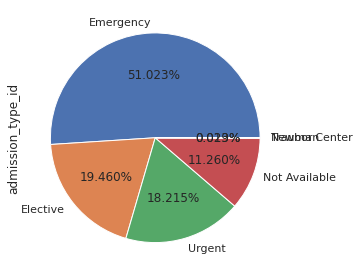

In [28]:
p = admission_types.value_counts()
_ = p.plot.pie(autopct="%.3f%%")
plt.tight_layout()

## 6.4 Discharges 
The `discharge_disposition_id` feature indicates how a patient was discharged from the hospital. It tracks 29 possible values:

In [29]:
ld.load_mapping('discharge_disposition_id').description.unique()

array(['Discharged to home',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to SNF', 'Discharged/transferred to ICF',
       'Discharged/transferred to another type of inpatient care institution',
       'Discharged/transferred to home with home health service',
       'Left AMA',
       'Discharged/transferred to home under care of Home IV provider',
       'Admitted as an inpatient to this hospital',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Expired',
       'Still patient or expected to return for outpatient services',
       'Hospice / home', 'Hospice / medical facility',
       'Discharged/transferred within this institution to Medicare approved swing bed',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/referred to this institution for outpatient services',
       nan, 'Expired at home. Medicaid only, hospice.',
       'Expired

In [30]:
discharges = ld.convert_id_to_discharge_disposition(df.discharge_disposition_id)
discharges.value_counts(normalize=True, dropna=False)

Discharged to home                                                                                           0.619671
Discharged/transferred to SNF                                                                                0.122824
Discharged/transferred to home with home health service                                                      0.115903
NaN                                                                                                          0.034593
Discharged/transferred to another short term hospital                                                        0.021519
Discharged/transferred to another rehab fac including rehab units of a hospital .                            0.019716
Expired                                                                                                      0.015059
Discharged/transferred to another type of inpatient care institution                                         0.012766
Not Mapped                                              

Similar to admission type, missing values span three values: NaN (18), Not Mapped (25), and Unknown/Invalid (26). We will again assume no distinction between the three and bucket them into an existing value, e.g. "Not Mapped."

In [31]:
df.discharge_disposition_id.replace(18, 25, inplace=True)
df.discharge_disposition_id.replace(26, 25, inplace=True)
df.discharge_disposition_id = df.discharge_disposition_id.astype('category')
discharges = ld.convert_id_to_discharge_disposition(df.discharge_disposition_id)
discharges.value_counts(normalize=True, dropna=False)

Discharged to home                                                                                           0.619671
Discharged/transferred to SNF                                                                                0.122824
Discharged/transferred to home with home health service                                                      0.115903
Not Mapped                                                                                                   0.045472
Discharged/transferred to another short term hospital                                                        0.021519
Discharged/transferred to another rehab fac including rehab units of a hospital .                            0.019716
Expired                                                                                                      0.015059
Discharged/transferred to another type of inpatient care institution                                         0.012766
Discharged/transferred to ICF                           

## 6.4 Admission source
The `admission_source_id` feature specifies from where the patient was admitted for this encounter. It tracks 26 possible values:

In [32]:
ld.load_mapping('admission_source_id').description.unique()

array(['Physician Referral', 'Clinic Referral', 'HMO Referral',
       'Transfer from a hospital',
       'Transfer from a Skilled Nursing Facility (SNF)',
       'Transfer from another health care facility', 'Emergency Room',
       'Court/Law Enforcement', 'Not Available',
       'Transfer from critial access hospital', 'Normal Delivery',
       'Premature Delivery', 'Sick Baby', 'Extramural Birth', nan,
       'Transfer From Another Home Health Agency',
       'Readmission to Same Home Health Agency', 'Not Mapped',
       'Unknown/Invalid',
       'Transfer from hospital inpt/same fac reslt in a sep claim',
       'Born inside this hospital', 'Born outside this hospital',
       'Transfer from Ambulatory Surgery Center', 'Transfer from Hospice'],
      dtype=object)

In [33]:
admission_sources = ld.convert_id_to_admission_source(df.admission_source_id)
admission_sources.value_counts(normalize=True, dropna=False)

Emergency Room                                               0.535397
Physician Referral                                           0.307717
NaN                                                          0.069200
Transfer from a hospital                                     0.036103
Transfer from another health care facility                   0.025183
Clinic Referral                                              0.012948
Transfer from a Skilled Nursing Facility (SNF)               0.007621
Not Mapped                                                   0.002167
HMO Referral                                                 0.001930
Not Available                                                0.001328
Court/Law Enforcement                                        0.000168
Transfer from critial access hospital                        0.000098
Transfer from hospital inpt/same fac reslt in a sep claim    0.000056
Extramural Birth                                             0.000028
Transfer from Ambula

Missing values map to NaN (17), Not Available (15), Not Mapped (20), Unknown/Invalid (21). We conflate these values by bucketing them in "Not Available."

In [34]:
df.admission_source_id.replace(17, 15, inplace=True)
df.admission_source_id.replace(20, 15, inplace=True)
df.admission_source_id.replace(21, 15, inplace=True)
df.admission_source_id = df.admission_source_id.astype('category')
admission_sources = ld.convert_id_to_admission_source(df.admission_source_id)
admission_sources.value_counts(normalize=True, dropna=False)

Emergency Room                                               0.535397
Physician Referral                                           0.307717
Not Available                                                0.072696
Transfer from a hospital                                     0.036103
Transfer from another health care facility                   0.025183
Clinic Referral                                              0.012948
Transfer from a Skilled Nursing Facility (SNF)               0.007621
HMO Referral                                                 0.001930
Court/Law Enforcement                                        0.000168
Transfer from critial access hospital                        0.000098
Transfer from hospital inpt/same fac reslt in a sep claim    0.000056
Extramural Birth                                             0.000028
Transfer from Ambulatory Surgery Center                      0.000028
Normal Delivery                                              0.000014
Sick Baby           

## 6.5 Early readmission
`readmitted` is "NO" if the patient was not readmitted back into the hospital, "<30" if the patient was readmitted within 30 days, and ">30" if the patient was readmitted after 30 days. Our objective is to predict early readmission so we must convert this into a binary feature. After conversion, we expect to have a 9:1 split between no early readmission and early readmission.

In [35]:
df.readmitted.value_counts(normalize=True, dropna=False)

NO     0.601032
>30    0.310975
<30    0.087993
Name: readmitted, dtype: float64

In [36]:
df['is_readmitted_early'] = df['readmitted']
df.is_readmitted_early.replace('>30', 0, inplace=True)
df.is_readmitted_early.replace('NO', 0, inplace=True)
df.is_readmitted_early.replace('<30', 1, inplace=True)
df.is_readmitted_early = df.is_readmitted_early.astype('category')
df.is_readmitted_early.value_counts(normalize=True, dropna=False)

0    0.912007
1    0.087993
Name: is_readmitted_early, dtype: float64

We now drop the vesitigial `readmitted` column:

In [37]:
df.drop(columns=['readmitted'], errors='ignore', inplace=True)

# 7. Handling Outliers for Numerical Features

There are no missing values for numerical features. Therefore, we seek to identify outliers or anomalous values.

The `time_in_hospital` features tracks the number of days the patient was in the hospital. We'll rename this column for more specificity:

In [38]:
df = df.rename(columns={'time_in_hospital': 'days_in_hospital'})

Let's see a statistical summary for our numerical features:

In [39]:
numerical_features = df._get_numeric_data()
numerical_features.describe()

,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,71517.000000,71517.000000,71517.000000,71517.000000,71517.000000,71517.000000,71517.000000,71517.000000
mean,4.289092,43.076066,1.430569,15.705049,0.280073,0.103542,0.177818,7.245732
std,2.949213,19.951857,1.759875,8.311218,1.068964,0.509190,0.603786,1.994671
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


There are clearly some outliers in features like `num_lab_procedures`, `num_medications`, `number_outpatient`, and `num_emergency`. 

In [40]:
def proportion_of_outliers(col):
    """
    Returns the proportion of outliers for a column
    """
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3-q1
    minx = q1 - 1.5*iqr
    maxx = q3 + 1.5*iqr
    return (col[col > maxx].count() + col[col < minx].count()) / len(col)

def outliers_by_iqr(df, feature):
    """
    Returns the portion of a dataframe's feature that consists of outliers
    """
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1
    minx = q1 - 1.5*iqr
    maxx = q3 + 1.5*iqr
    return df[(df[feature] > maxx) | (df[feature] < minx)]

Here's a mapping from feature to its number of outliers:

In [41]:
feature_outliers = dict()
for i, c in enumerate(numerical_features.columns):
    num_outliers = outliers_by_iqr(df, c).shape[0]
    feature_outliers[c] = num_outliers
feature_outliers

{'days_in_hospital': 1464,
 'num_lab_procedures': 114,
 'num_procedures': 3956,
 'num_medications': 1925,
 'number_outpatient': 9306,
 'number_emergency': 5204,
 'number_inpatient': 8440,
 'number_diagnoses': 236}

Let's see the proportion of outliers per feature, grouped by early readmission:

In [42]:
cols = list(numerical_features.columns) + ['is_readmitted_early']
df[cols].groupby('is_readmitted_early').apply(lambda x: x.apply(lambda y: proportion_of_outliers(y)))

,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
is_readmitted_early,,,,,,,,
0,0.020085,0.001533,0.055700,0.026616,0.128404,0.070358,0.109960,0.003450
1,0.000000,0.002225,0.051327,0.027014,0.147942,0.097728,0.201494,0.001748


We see that for some features like number of emergency visits, days in the hospital, and number of outpatient visits, there is a difference in the proportion of outliers. I'm hesitant to remove these outliers just yet, because I'm interested in applying outlier-robust, tree-based algorithms on this untransformed data. However, during the feature engineering phase, I will also apply this transformation to experiment with less robust algorithms.

# 8. Exporting Preprocessed Data
Save the pre-processed data into a csv and pickle file.

In [43]:
original_shape, df.shape

((101766, 49), (71517, 47))

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71517 entries, (12522, 48330783) to (443867222, 175429310)
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      71517 non-null  object  
 1   gender                    71517 non-null  object  
 2   age                       71517 non-null  object  
 3   admission_type_id         71517 non-null  category
 4   discharge_disposition_id  71517 non-null  category
 5   admission_source_id       71517 non-null  category
 6   days_in_hospital          71517 non-null  int64   
 7   payer_code                71517 non-null  category
 8   medical_specialty         71517 non-null  category
 9   num_lab_procedures        71517 non-null  int64   
 10  num_procedures            71517 non-null  int64   
 11  num_medications           71517 non-null  int64   
 12  number_outpatient         71517 non-null  int64   
 13  number_emerge

In [45]:
df.to_csv(ld.find_interim_path('00_diabetes.csv'))

In [46]:
df.to_pickle(ld.find_interim_path('00_diabetes.pkl'))